In [1]:
import skimage.external.tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as dataf
import torch.nn as nn

In [2]:
Data = tiff.imread('data/CASI_SC_tif.tif')
TsLabel = tiff.imread('data/Test_sample.tif')
TrLabel = tiff.imread('data/Train_samples.tif')

In [3]:
batchsize = 128
LR = 0.001
EPOCH = 200
EPOCH2 = 200

In [4]:
[l, m, n] = Data.shape
Data = Data.astype('float32')
for i in range(l):
    minimal = Data[i, :, :].min()
    maximal = Data[i, :, :].max()
    Data[i, :, :] = (Data[i, :, :] - minimal)/(maximal - minimal)

In [5]:
TotalData = np.reshape(Data, [m*n, l])
TrainDataLabel = np.reshape(TrLabel, [m*n, 1])
Tr_index, _ = np.where(TrainDataLabel != 0)
TrainData1 = TotalData[Tr_index, :]
TrainDataLabel = TrainDataLabel[Tr_index, 0]
TestDataLabel = np.reshape(TsLabel, [m*n, 1])
Ts_index, _ = np.where(TestDataLabel != 0)
TestData1 = TotalData[Ts_index, :]
TestDataLabel = TestDataLabel[Ts_index, 0]
# construct data for network

TrainData = np.empty((len(TrainDataLabel), l, 1), dtype='float32')
TestData = np.empty((len(TestDataLabel), l, 1), dtype='float32')

for i in range(len(TrainDataLabel)):
    temp = TrainData1[i, :]
    temp = np.transpose(temp)
    TrainData[i, :, 0] = temp

for i in range(len(TestDataLabel)):
    temp = TestData1[i, :]
    temp = np.transpose(temp)
    TestData[i, :, 0] = temp

print('Training size and testing size are:', TrainData.shape, 'and', TestData.shape)

Training size and testing size are: (2832, 144, 1) and (12197, 144, 1)


In [6]:
TrainData = torch.from_numpy(TrainData)
TrainDataLabel = torch.from_numpy(TrainDataLabel)-1
TrainDataLabel = TrainDataLabel.long()
dataset = dataf.TensorDataset(TrainData, TrainDataLabel)
train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True)

TestData = torch.from_numpy(TestData)
TestDataLabel = torch.from_numpy(TestDataLabel)-1
TestDataLabel = TestDataLabel.long()

# train_loader for AE using training and test data together
TrainData2 = torch.cat([TrainData, TestData], 0)
TrainDataLabel2 = torch.cat([TrainDataLabel, TestDataLabel], 0)
dataset2 = dataf.TensorDataset(TrainData2, TrainDataLabel2)
train_loader2 = dataf.DataLoader(dataset2, batch_size=batchsize, shuffle=True)
print('Training size for reconstruction', TrainData2.shape)


Classes = len(np.unique(TrainDataLabel))

Training size for reconstruction torch.Size([15029, 144, 1])


In [7]:
# construct the reconstruction network
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(TrainData.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, TrainData.shape[1]),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
ae = AE()
ae.cuda()
print(ae)

optimizer = torch.optim.Adam(ae.parameters(), lr=LR)
# loss_func = nn.MSELoss()
loss_func = nn.MSELoss()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=144, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=144, bias=True)
    (5): Sigmoid()
  )
)


In [9]:
BestAcc = 100

# train the AE and save the best model
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader2):  # gives batch data
        b_x = b_x.cuda()
        b_x = b_x.view(-1, TrainData.shape[1])
        output = ae(b_x)  # rnn output      
        loss = loss_func(output, b_x)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if step % 50 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy())
            # save the parameters in network
            if loss.data.cpu().numpy() < BestAcc:
                torch.save(ae.state_dict(), 'net_params_AERecons.pkl')
                BestAcc = loss.data.cpu().numpy()

Epoch:  0 | train loss: 0.1649
Epoch:  0 | train loss: 0.0117
Epoch:  0 | train loss: 0.0044
Epoch:  1 | train loss: 0.0039
Epoch:  1 | train loss: 0.0027
Epoch:  1 | train loss: 0.0033
Epoch:  2 | train loss: 0.0036
Epoch:  2 | train loss: 0.0028
Epoch:  2 | train loss: 0.0026
Epoch:  3 | train loss: 0.0020
Epoch:  3 | train loss: 0.0028
Epoch:  3 | train loss: 0.0024
Epoch:  4 | train loss: 0.0032
Epoch:  4 | train loss: 0.0024
Epoch:  4 | train loss: 0.0022
Epoch:  5 | train loss: 0.0026
Epoch:  5 | train loss: 0.0017
Epoch:  5 | train loss: 0.0022
Epoch:  6 | train loss: 0.0029
Epoch:  6 | train loss: 0.0020
Epoch:  6 | train loss: 0.0030
Epoch:  7 | train loss: 0.0024
Epoch:  7 | train loss: 0.0034
Epoch:  7 | train loss: 0.0027
Epoch:  8 | train loss: 0.0029
Epoch:  8 | train loss: 0.0030
Epoch:  8 | train loss: 0.0025
Epoch:  9 | train loss: 0.0024
Epoch:  9 | train loss: 0.0022
Epoch:  9 | train loss: 0.0028
Epoch:  10 | train loss: 0.0026
Epoch:  10 | train loss: 0.0022
Epoch:

Epoch:  85 | train loss: 0.0009
Epoch:  86 | train loss: 0.0008
Epoch:  86 | train loss: 0.0009
Epoch:  86 | train loss: 0.0010
Epoch:  87 | train loss: 0.0009
Epoch:  87 | train loss: 0.0010
Epoch:  87 | train loss: 0.0009
Epoch:  88 | train loss: 0.0009
Epoch:  88 | train loss: 0.0010
Epoch:  88 | train loss: 0.0009
Epoch:  89 | train loss: 0.0010
Epoch:  89 | train loss: 0.0009
Epoch:  89 | train loss: 0.0009
Epoch:  90 | train loss: 0.0010
Epoch:  90 | train loss: 0.0009
Epoch:  90 | train loss: 0.0010
Epoch:  91 | train loss: 0.0011
Epoch:  91 | train loss: 0.0009
Epoch:  91 | train loss: 0.0008
Epoch:  92 | train loss: 0.0010
Epoch:  92 | train loss: 0.0010
Epoch:  92 | train loss: 0.0010
Epoch:  93 | train loss: 0.0010
Epoch:  93 | train loss: 0.0011
Epoch:  93 | train loss: 0.0009
Epoch:  94 | train loss: 0.0009
Epoch:  94 | train loss: 0.0011
Epoch:  94 | train loss: 0.0010
Epoch:  95 | train loss: 0.0010
Epoch:  95 | train loss: 0.0011
Epoch:  95 | train loss: 0.0009
Epoch:  

Epoch:  169 | train loss: 0.0008
Epoch:  169 | train loss: 0.0008
Epoch:  170 | train loss: 0.0007
Epoch:  170 | train loss: 0.0007
Epoch:  170 | train loss: 0.0007
Epoch:  171 | train loss: 0.0007
Epoch:  171 | train loss: 0.0009
Epoch:  171 | train loss: 0.0008
Epoch:  172 | train loss: 0.0008
Epoch:  172 | train loss: 0.0007
Epoch:  172 | train loss: 0.0008
Epoch:  173 | train loss: 0.0008
Epoch:  173 | train loss: 0.0007
Epoch:  173 | train loss: 0.0008
Epoch:  174 | train loss: 0.0010
Epoch:  174 | train loss: 0.0008
Epoch:  174 | train loss: 0.0008
Epoch:  175 | train loss: 0.0007
Epoch:  175 | train loss: 0.0007
Epoch:  175 | train loss: 0.0008
Epoch:  176 | train loss: 0.0008
Epoch:  176 | train loss: 0.0008
Epoch:  176 | train loss: 0.0007
Epoch:  177 | train loss: 0.0008
Epoch:  177 | train loss: 0.0008
Epoch:  177 | train loss: 0.0010
Epoch:  178 | train loss: 0.0007
Epoch:  178 | train loss: 0.0008
Epoch:  178 | train loss: 0.0007
Epoch:  179 | train loss: 0.0008
Epoch:  17

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(TrainData.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),

            # nn.Linear(TrainData.shape[1], 128),
            # nn.ReLU(),
            # nn.Linear(128, 128),
            # nn.ReLU(),
        )

        self.output = nn.Linear(128, Classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.output(x)
        return x

In [11]:
classifier = Classifier()
classifier.cuda()
print(classifier)

optimizer = torch.optim.Adam(classifier.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

Classifier(
  (encoder): Sequential(
    (0): Linear(in_features=144, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
  )
  (output): Linear(in_features=128, out_features=15, bias=True)
)


In [12]:
model_parameters = filter(lambda p: p.requires_grad, classifier.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

17007


In [13]:
model_dict = classifier.state_dict()
pretrained_dict = torch.load('net_params_AERecons.pkl')
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
classifier.load_state_dict(model_dict)

<All keys matched successfully>

In [14]:
BestAcc = 0

# training and testing
for epoch in range(EPOCH2):
    for step, (b_x, b_y) in enumerate(train_loader):  # gives batch data
        b_x = b_x.cuda()
        b_x = b_x.view(-1, TrainData.shape[1])
        b_y = b_y.cuda()
        output = classifier(b_x)  # rnn output    
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
        

        if step % 50 == 0:

            classifier.eval()  # in the testing phase, we don't need to use dropout

            # divide test set into many subsets
            pred_y = np.empty((len(TestDataLabel)), dtype='float32')
            number = len(TestDataLabel) // 5000
            for i in range(number):
                temp = TestData[i * 5000:(i + 1) * 5000, :, :]
                temp = temp.cuda()
                temp = temp.view(-1, TrainData.shape[1])
                temp2 = classifier(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[i * 5000:(i + 1) * 5000] = temp3.cpu()
                del temp, temp2, temp3

            if (i + 1) * 5000 < len(TestDataLabel):
                temp = TestData[(i + 1) * 5000:len(TestDataLabel), :, :]
                temp = temp.cuda()
                temp = temp.view(-1, TrainData.shape[1])
                temp2 = classifier(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[(i + 1) * 5000:len(TestDataLabel)] = temp3.cpu()
                del temp, temp2, temp3

            pred_y = torch.from_numpy(pred_y).long()
            accuracy = torch.sum(pred_y == TestDataLabel).type(torch.FloatTensor) / TestDataLabel.size(0)
            # test_output = rnn(TestData)
            # pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            # accuracy = torch.sum(pred_y == TestDataLabel).type(torch.FloatTensor) / TestDataLabel.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)

            if accuracy > BestAcc:
                torch.save(classifier.state_dict(), 'net_params_AEClass.pkl')
                BestAcc = accuracy

            classifier.train()  # in the training phase, we need to use dropout again


Epoch:  0 | train loss: 2.8256 | test accuracy: 0.02
Epoch:  1 | train loss: 2.6837 | test accuracy: 0.08
Epoch:  2 | train loss: 2.6416 | test accuracy: 0.08
Epoch:  3 | train loss: 2.6241 | test accuracy: 0.07
Epoch:  4 | train loss: 2.6111 | test accuracy: 0.07
Epoch:  5 | train loss: 2.6085 | test accuracy: 0.07
Epoch:  6 | train loss: 2.6404 | test accuracy: 0.07
Epoch:  7 | train loss: 2.6416 | test accuracy: 0.07
Epoch:  8 | train loss: 2.5295 | test accuracy: 0.07
Epoch:  9 | train loss: 2.5783 | test accuracy: 0.06
Epoch:  10 | train loss: 2.6248 | test accuracy: 0.07
Epoch:  11 | train loss: 2.6166 | test accuracy: 0.07
Epoch:  12 | train loss: 2.5511 | test accuracy: 0.07
Epoch:  13 | train loss: 2.5821 | test accuracy: 0.07
Epoch:  14 | train loss: 2.5607 | test accuracy: 0.07
Epoch:  15 | train loss: 2.5191 | test accuracy: 0.06
Epoch:  16 | train loss: 2.5575 | test accuracy: 0.06
Epoch:  17 | train loss: 2.4940 | test accuracy: 0.06
Epoch:  18 | train loss: 2.5666 | test

Epoch:  151 | train loss: 2.1787 | test accuracy: 0.07
Epoch:  152 | train loss: 2.1806 | test accuracy: 0.07
Epoch:  153 | train loss: 2.1980 | test accuracy: 0.07
Epoch:  154 | train loss: 2.2081 | test accuracy: 0.07
Epoch:  155 | train loss: 2.1848 | test accuracy: 0.07
Epoch:  156 | train loss: 2.1022 | test accuracy: 0.07
Epoch:  157 | train loss: 2.1289 | test accuracy: 0.07
Epoch:  158 | train loss: 2.2208 | test accuracy: 0.07
Epoch:  159 | train loss: 2.0901 | test accuracy: 0.08
Epoch:  160 | train loss: 2.1591 | test accuracy: 0.07
Epoch:  161 | train loss: 2.0998 | test accuracy: 0.07
Epoch:  162 | train loss: 2.1605 | test accuracy: 0.07
Epoch:  163 | train loss: 2.0592 | test accuracy: 0.07
Epoch:  164 | train loss: 2.1482 | test accuracy: 0.07
Epoch:  165 | train loss: 2.0583 | test accuracy: 0.07
Epoch:  166 | train loss: 2.0992 | test accuracy: 0.07
Epoch:  167 | train loss: 2.1559 | test accuracy: 0.07
Epoch:  168 | train loss: 2.1715 | test accuracy: 0.07
Epoch:  16

In [15]:
classifier.load_state_dict(torch.load('net_params_AEClass.pkl'))
classifier.eval()
pred_y = np.empty((len(TestDataLabel)), dtype='float32')
number = len(TestDataLabel)//5000
for i in range(number):
    temp = TestData[i*5000:(i+1)*5000, :, :]
    temp = temp.cuda()
    temp = temp.view(-1, TrainData.shape[1])
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[i*5000:(i+1)*5000] = temp3.cpu()
    del temp, temp2, temp3

if (i+1)*5000 < len(TestDataLabel):
    temp = TestData[(i+1)*5000:len(TestDataLabel), :, :]
    temp = temp.cuda()
    temp = temp.view(-1, TrainData.shape[1])
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[(i+1)*5000:len(TestDataLabel)] = temp3.cpu()
    del temp, temp2, temp3

pred_y = torch.from_numpy(pred_y).long()
OA = torch.sum(pred_y == TestDataLabel).type(torch.FloatTensor) / TestDataLabel.size(0)

Classes = np.unique(TestDataLabel)
EachAcc = np.empty(len(Classes))

for i in range(len(Classes)):
    cla = Classes[i]
    right = 0
    sum = 0

    for j in range(len(TestDataLabel)):
        if TestDataLabel[j] == cla:
            sum += 1
        if TestDataLabel[j] == cla and pred_y[j] == cla:
            right += 1

    EachAcc[i] = right.__float__()/sum.__float__()


print(OA)
print(EachAcc)

tensor(0.0833)
[0.01329535 0.15977444 0.01386139 0.         0.02746212 0.03496503
 0.11100746 0.0968661  0.36355052 0.10617761 0.0028463  0.03842459
 0.10526316 0.         0.00422833]


In [16]:
D = np.empty((m*n, l, 1), dtype='float32')
pred_all = np.empty((m*n, 1), dtype='float32')
count = 0
for i in range(m*n):
    temp = TotalData[i, :]
    temp = np.transpose(temp)
    D[count, :, 0] = temp
    count += 1

del temp
# D = torch.from_numpy(D)
number = m*n//5000
for i in range(number):
    temp = D[i*5000:(i+1)*5000, :, :]
    temp = torch.from_numpy(temp)
    temp = temp.cuda()
    temp = temp.view(-1, TrainData.shape[1])
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[i*5000:(i+1)*5000, 0] = temp3.cpu()
    del temp, temp2, temp3


if (i+1)*5000 < m*n:
    temp = D[(i+1)*5000:m*n, :, :]
    temp = torch.from_numpy(temp)
    temp = temp.cuda()
    temp = temp.view(-1, TrainData.shape[1])
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[(i+1)*5000:m*n, 0] = temp3.cpu()
    del temp, temp2, temp3


pred_all = np.reshape(pred_all, (m, n)) + 1
OA = OA.numpy()
pred_y = pred_y.cpu()
pred_y = pred_y.numpy()
TestDataLabel = TestDataLabel.cpu()
TestDataLabel = TestDataLabel.numpy()


In [17]:
tiff.imsave('pred_ae.tif', pred_all)
# pred_all = tiff.imread('pred_ae.tif')

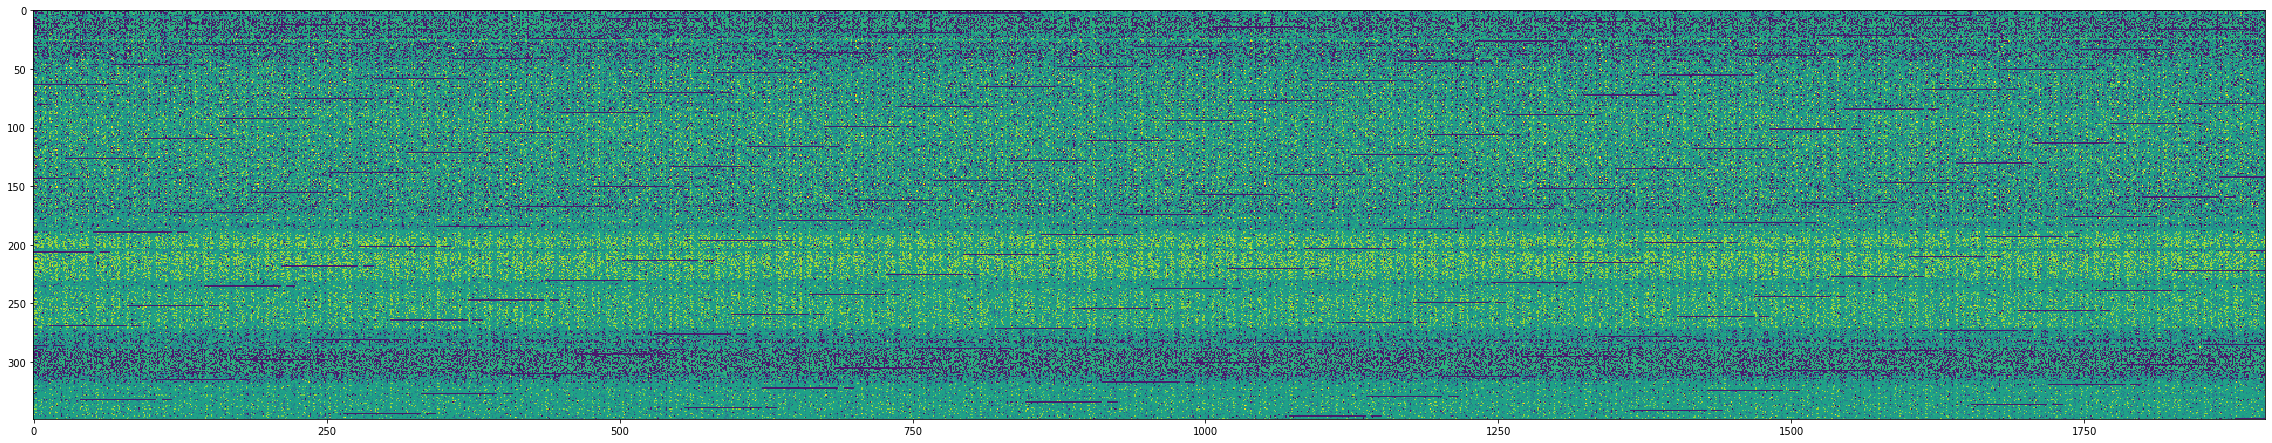

In [18]:
plt.figure(figsize=(40,40))
plt.imshow(pred_all)
plt.show()